In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import warnings
# importing os module 
import os
# Imports PIL module 
from keras.models import Model
from PIL import Image # for grabbing images
import tensorflow as tf
from itertools import chain #for target labels 
import keras
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [9]:
# Grab all images 

path_of_input_image_classes="AID"
class_names = os.listdir(path_of_input_image_classes) 
class_names = [i for i in class_names if i != '.DS_Store'] # Gave me an extraneous class, delete it if it appears
num_of_output_classes=len(class_names);
print('Number of classes in total:\n')
print(num_of_output_classes);
class_names.sort()
print('\nTerrain Classes:\n')
print(class_names)
num_of_images_in_classes = []
all_images = []

for dir in class_names:
    filenames = os.listdir(os.path.join(path_of_input_image_classes,dir))
    num_of_images_in_classes.append(len(filenames)) # Stores length of each class
    for file in filenames:
        image = Image.open(os.path.join(path_of_input_image_classes, dir, file))
        image = cv2.imread(os.path.join(path_of_input_image_classes, dir, file))
        image = cv2.resize(image,(214,214))
        all_images.append(image)

Number of classes in total:

15

Terrain Classes:

['Airport', 'Beach', 'Bridge', 'DenseResidental', 'Desert', 'Farmland', 'Forest', 'Meadow', 'MediumResidental', 'Mountain', 'Parking', 'River', 'School', 'SparseResidential', 'Stadium']


In [10]:
Images=np.array(all_images) # this is 10,000 images x pixel num x pixel num x RGB val(3)
print(Images.shape)

(4208, 214, 214, 3)


In [11]:
# Make target labels
target_labels=[];
class_label=0;
for i in range(num_of_output_classes): # 0 to 29 
    num_of_images_current_class=num_of_images_in_classes[i]
    append_num=[class_label] * num_of_images_current_class
    target_labels.append(append_num)
    class_label=class_label+1
target_labels = list(chain.from_iterable(target_labels))
target_labels=np.array(target_labels)

## Split into Training and Testing

In [12]:
# Split into training and testing 
X_train, X_test,t_train, t_test = train_test_split(Images,target_labels,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
X_train.shape, X_test.shape, t_train.shape, t_test.shape

np.save("test_data.npy",X_test)
np.save("test_labels.npy",t_test)

## Training on all images

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 214, 214, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 214, 214, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 214, 214, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 107, 107, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 107, 107, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 107, 107, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 53, 53, 128)       0   

2023-03-28 23:17:54.497203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-03-28 23:17:55.698783: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-03-28 23:17:55.945805: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-28 23:17:57.568340: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


106/106 [==============================] - 11s 49ms/step - loss: 1.1696 - accuracy: 0.6129
Epoch 2/5
106/106 [==============================] - 5s 45ms/step - loss: 0.4112 - accuracy: 0.8678
Epoch 3/5
106/106 [==============================] - 5s 45ms/step - loss: 0.1923 - accuracy: 0.9364
Epoch 4/5
106/106 [==============================] - 5s 45ms/step - loss: 0.1406 - accuracy: 0.9563
Epoch 5/5
106/106 [==============================] - 5s 45ms/step - loss: 0.1580 - accuracy: 0.9424


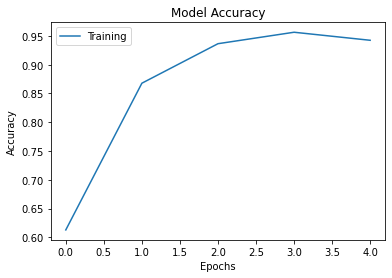

In [14]:
# train VGG16 CNN
train_transfer_learning_CNN(num_of_output_classes,X_train,t_train, img_size=214, epochs=5, learning_rate=1e-4)

In [15]:
# Print confusion matrix
def conf_matrix_w_acc(y_test, labels):
    # Evaluate trained model in validation set
    cm = confusion_matrix(y_test, labels)
    acc =np.diagonal(cm).sum()/ cm.sum()
    # acc = accuracy_score(y_test,labels)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True ,fmt='g', xticklabels = class_names, yticklabels = class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix (Accuracy = %f)' % acc, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [16]:
def test(class_num,X_test,labels_test,model_name='vgg16_trained_cnn.hdf5',resized_pixel_size=214): 
        #Get Test Data Information, mainly for clarification on our end 
    
 
        #Reshpaing for input into model 
        X_test = X_test/255.
        
        #Setting up labels for keras model
        labels_test_model = np_utils.to_categorical(labels_test, num_classes=class_num)

        # Loads trained model 
        model = keras.models.load_model(model_name)

        #Can print model summary for illustration purposes
        #print(model.summary())

        #Evaluating model on test data 
        loss,accuracy=model.evaluate(X_test,labels_test_model)

        #Generates probability matrix of label assignment 
        y_proba = model.predict(X_test)

        #Grabs largest probability for each photo belonging to a certain class 
        y_classes = np.argmax(y_proba,axis=1)

        #Prints confustion matrix 
        print(conf_matrix_w_acc(labels_test, y_classes))
        
        return accuracy,y_classes

## Test Performance 

27/27 [==============================] - 1s 28ms/step - loss: 0.2183 - accuracy: 0.9311
None


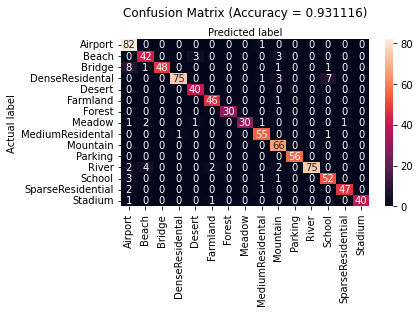

In [17]:
accuracy,y_classes=test(num_of_output_classes,X_test,t_test,model_name='vgg16_trained_cnn.hdf5',resized_pixel_size=214)

## Training performance when randomly pulling out 20% of the data

In [ ]:
per_keep=.8 #keep 80% of data
X_train_rand=X_train[0:int(per_keep*X_train.shape[0]),:,:,:]
t_train_rand=t_train[0:int(per_keep*t_train.shape[0])]
print("New Training shape")
print(t_train_rand.shape)
print(X_train_rand.shape)

train_transfer_learning_CNN(num_of_output_classes,X_train_rand,t_train_rand, img_size=214, epochs=5, learning_rate=1e-4)

New Training shape
(2692,)
(2692, 214, 214, 3)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 214, 214, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 214, 214, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 214, 214, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 107, 107, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 107, 107, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 107, 107, 128)     147584    
                                                                 
 block2_pool